### ALGORITHMS TO BE EVALUATED
1. K-Means k ∈ [2,10] — Baseline; fast, interpretable, scalable
2. Gaussian Mixture k ∈ [2,10] — Soft clustering; handles elliptical shapes
3. Agglomerative k ∈ [2,10] — Hierarchical; no k assumption needed upfront
4. DBSCAN eps sweep — Density-based; finds arbitrary shapes + noise

### METRICS USED (triangulated — no single metric is sufficient)
1. Silhouette Score ↑ higher is better [-1, 1] intra/inter cohesion ratio
2. Davies-Bouldin      ↓ lower  is better  [0, ∞]   cluster separation quality
3. Calinski-Harabasz   ↑ higher is better  [0, ∞]   between/within variance ratio
4. Inertia (WCSS)      ↓ elbow method      K-Means only
5. BIC / AIC           ↓ lower  is better  GMM only — penalises model complexity

### Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

import joblib

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [3]:
df = pd.read_csv("/content/customer_segmentation_features.csv")

In [4]:
X = df[['log_minutes_watched_scaled', 'log_clv_scaled']].values

In [5]:
print(f"Feature matrix shape : {X.shape}")
print(f"Clustering inputs    : log_minutes_scaled, log_clv_scaled")

Feature matrix shape : (3791, 2)
Clustering inputs    : log_minutes_scaled, log_clv_scaled


In [6]:
K_RANGE = range(2, 11)

CHANNEL_MAP    = {1:'Google', 2:'Facebook', 3:'YouTube', 4:'LinkedIn',
                  5:'Twitter', 6:'Instagram', 7:'Friend', 8:'Other'}

REGION_MAP     = {0:'US/CA/UK/AU', 1:'W. Europe', 2:'Rest of World'}

ENGAGEMENT_MAP = {0:'Dormant', 1:'Low', 2:'Medium', 3:'High', 4:'Power'}

### K-MEANS (k = 2 → 10)

In [7]:
km_wcss, km_sil, km_db, km_ch, km_inertia = [], [], [], [], []

In [8]:
for k in K_RANGE:
    km = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=42)
    labels = km.fit_predict(X)
    km_inertia.append(km.inertia_)
    km_wcss.append(km.inertia_)
    km_sil.append(silhouette_score(X, labels))
    km_db.append(davies_bouldin_score(X, labels))
    km_ch.append(calinski_harabasz_score(X, labels))
    print(f"k={k:2d} | Inertia={km.inertia_:>10.1f} | "
          f"Sil={km_sil[-1]:.4f} | DB={km_db[-1]:.4f} | CH={km_ch[-1]:.1f}")

k= 2 | Inertia=    5184.3 | Sil=0.3538 | DB=1.1762 | CH=1752.5
k= 3 | Inertia=    3354.6 | Sil=0.3806 | DB=0.8810 | CH=2386.8
k= 4 | Inertia=    2752.6 | Sil=0.3399 | DB=0.8774 | CH=2214.7
k= 5 | Inertia=    2208.7 | Sil=0.3541 | DB=0.9156 | CH=2302.7
k= 6 | Inertia=    1879.7 | Sil=0.3636 | DB=0.8485 | CH=2296.4
k= 7 | Inertia=    1638.8 | Sil=0.3590 | DB=0.8598 | CH=2287.1
k= 8 | Inertia=    1410.1 | Sil=0.3634 | DB=0.8090 | CH=2365.5
k= 9 | Inertia=    1258.2 | Sil=0.3641 | DB=0.7873 | CH=2376.1
k=10 | Inertia=    1138.4 | Sil=0.3501 | DB=0.8208 | CH=2378.0


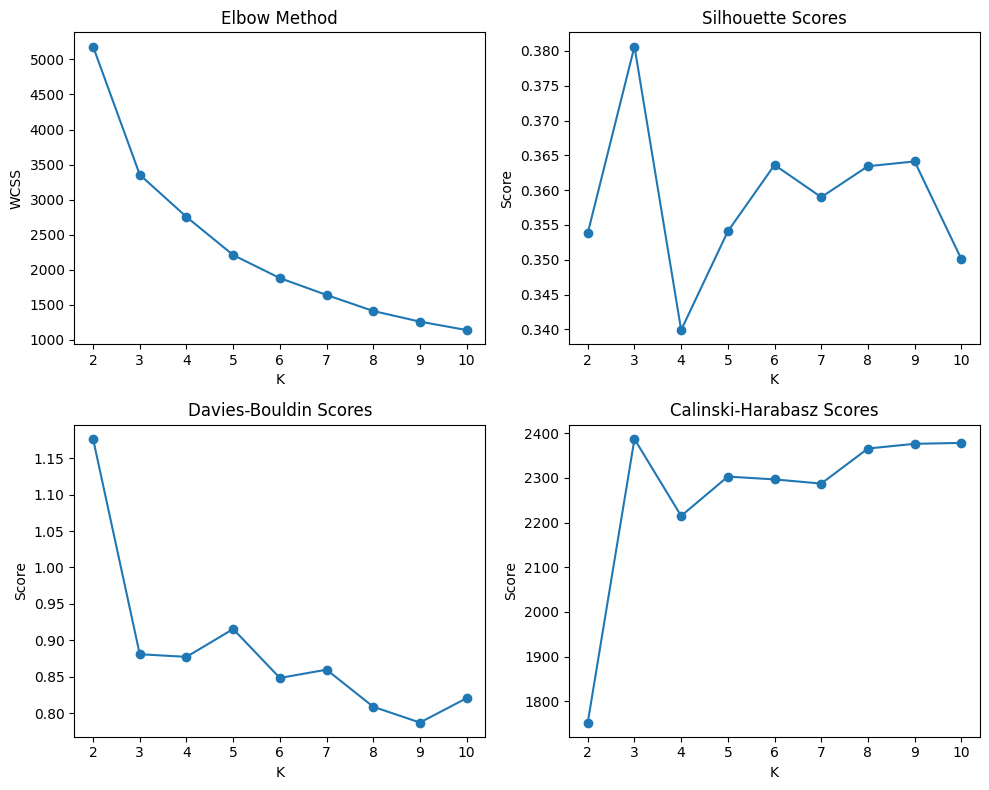

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

axes[0,0].plot(K_RANGE, km_wcss, marker='o')
axes[0,0].set_title('Elbow Method')
axes[0,0].set_xlabel('K')
axes[0,0].set_ylabel('WCSS')

axes[0,1].plot(K_RANGE, km_sil, marker='o')
axes[0,1].set_title('Silhouette Scores')
axes[0,1].set_xlabel('K')
axes[0,1].set_ylabel('Score')

axes[1,0].plot(K_RANGE, km_db, marker='o')
axes[1,0].set_title('Davies-Bouldin Scores')
axes[1,0].set_xlabel('K')
axes[1,0].set_ylabel('Score')

axes[1,1].plot(K_RANGE, km_ch, marker='o')
axes[1,1].set_title('Calinski-Harabasz Scores')
axes[1,1].set_xlabel('K')
axes[1,1].set_ylabel('Score')

plt.tight_layout()
plt.show()

### Gaussian Mixture Model (k = 2 → 10)

In [10]:
gmm_bic, gmm_aic, gmm_sil = [], [], []

In [11]:
for k in K_RANGE:
    gm = GaussianMixture(n_components=k, covariance_type='full', n_init=5, random_state=42)
    gm.fit(X)
    labels = gm.predict(X)
    gmm_bic.append(gm.bic(X))
    gmm_aic.append(gm.aic(X))
    gmm_sil.append(silhouette_score(X, labels))
    print(f"  k={k:2d} | BIC={gm.bic(X):>12.1f} | "
          f"AIC={gm.aic(X):>12.1f} | Sil={gmm_sil[-1]:.4f}")

  k= 2 | BIC=     20812.1 | AIC=     20743.4 | Sil=0.3160
  k= 3 | BIC=     20401.6 | AIC=     20295.6 | Sil=0.2386
  k= 4 | BIC=     16753.9 | AIC=     16610.4 | Sil=0.1432
  k= 5 | BIC=     16737.7 | AIC=     16556.8 | Sil=0.1342
  k= 6 | BIC=     16582.9 | AIC=     16364.5 | Sil=0.1818
  k= 7 | BIC=     16626.1 | AIC=     16370.2 | Sil=0.1797
  k= 8 | BIC=     16610.1 | AIC=     16316.8 | Sil=0.2181
  k= 9 | BIC=     16597.9 | AIC=     16267.1 | Sil=0.2272
  k=10 | BIC=     16648.9 | AIC=     16280.7 | Sil=0.2227


In [12]:
print(f"Best BIC → k={list(K_RANGE)[np.argmin(gmm_bic)]}  ({min(gmm_bic):.1f})")
print(f"Best AIC → k={list(K_RANGE)[np.argmin(gmm_aic)]}  ({min(gmm_aic):.1f})")
print(f"Best Silhouette Score → k={list(K_RANGE)[np.argmax(gmm_sil)]} ({max(gmm_sil):.4f})")

Best BIC → k=6  (16582.9)
Best AIC → k=9  (16267.1)
Best Silhouette Score → k=2 (0.3160)


### Agglomerative Clustering (k = 2 → 10, Ward linkage)

In [13]:
agg_sil, agg_db, agg_ch = [], [], []

In [14]:
for k in K_RANGE:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X)
    agg_sil.append(silhouette_score(X, labels))
    agg_db.append(davies_bouldin_score(X, labels))
    agg_ch.append(calinski_harabasz_score(X, labels))
    print(f"  k={k:2d} | Sil={agg_sil[-1]:.4f} | "
          f"DB={agg_db[-1]:.4f} | CH={agg_ch[-1]:.1f}")

  k= 2 | Sil=0.3225 | DB=1.1781 | CH=1541.2
  k= 3 | Sil=0.3499 | DB=0.9404 | CH=1994.7
  k= 4 | Sil=0.2995 | DB=0.9671 | CH=1906.5
  k= 5 | Sil=0.3238 | DB=0.9664 | CH=2050.0
  k= 6 | Sil=0.3211 | DB=0.9199 | CH=2035.4
  k= 7 | Sil=0.3291 | DB=0.8658 | CH=2029.9
  k= 8 | Sil=0.3300 | DB=0.8647 | CH=1985.2
  k= 9 | Sil=0.3287 | DB=0.8629 | CH=1975.9
  k=10 | Sil=0.2956 | DB=0.8990 | CH=1986.1


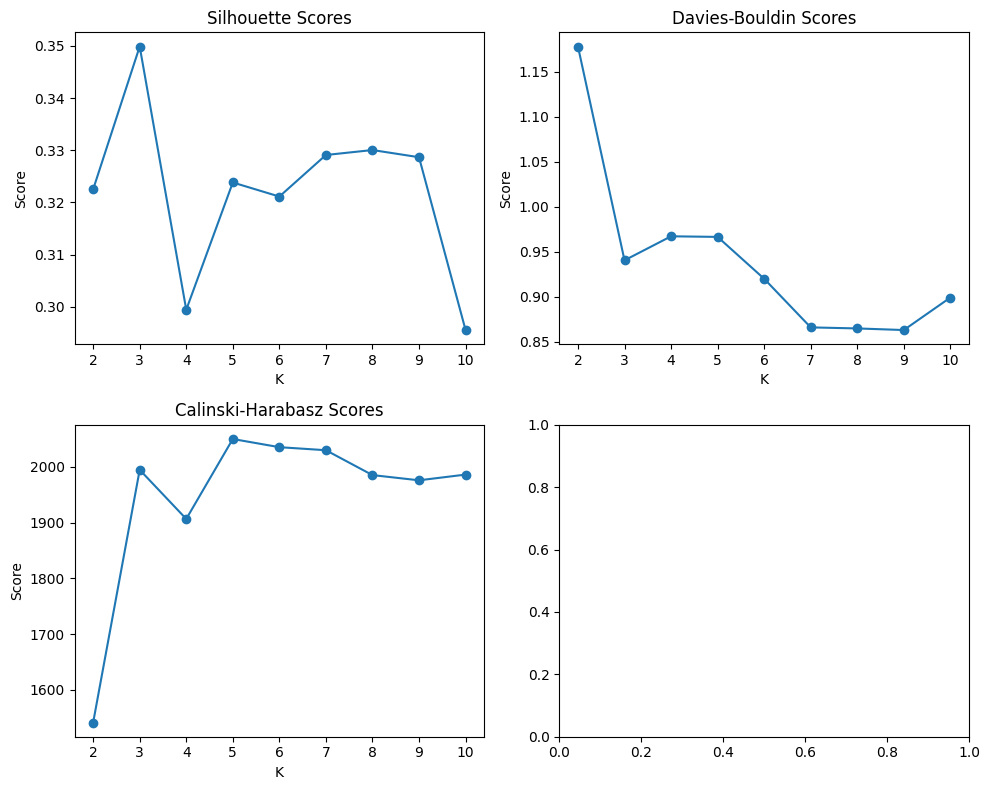

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

axes[0,0].plot(K_RANGE, agg_sil, marker='o')
axes[0,0].set_title('Silhouette Scores')
axes[0,0].set_xlabel('K')
axes[0,0].set_ylabel('Score')

axes[0,1].plot(K_RANGE, agg_db, marker='o')
axes[0,1].set_title('Davies-Bouldin Scores')
axes[0,1].set_xlabel('K')
axes[0,1].set_ylabel('Score')

axes[1,0].plot(K_RANGE, agg_ch, marker='o')
axes[1,0].set_title('Calinski-Harabasz Scores')
axes[1,0].set_xlabel('K')
axes[1,0].set_ylabel('Score')

plt.tight_layout()
plt.show()

### DBSCAN (eps sweep, min_samples=10)

In [16]:
eps_range = [0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.60, 0.80, 1.00]
dbscan_results = []

In [17]:
for eps in eps_range:
    db_model = DBSCAN(eps=eps, min_samples=10)
    labels = db_model.fit_predict(X)
    n_clust = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    sil = (silhouette_score(X, labels) if 1 < n_clust < len(X) - 1 else np.nan)
    dbscan_results.append({'eps': eps, 'n_clusters': n_clust, 'n_noise': n_noise, 'sil': sil})
    sil_str = f"{sil:.4f}" if not np.isnan(sil) else "N/A"
    print(f"  eps={eps:.2f} | clusters={n_clust:>3} | "
          f"noise={n_noise:>4} ({n_noise/len(X)*100:.1f}%) | Sil={sil_str}")

  eps=0.10 | clusters= 13 | noise= 924 (24.4%) | Sil=-0.2709
  eps=0.15 | clusters= 11 | noise= 556 (14.7%) | Sil=-0.1636
  eps=0.20 | clusters=  8 | noise= 301 (7.9%) | Sil=-0.0601
  eps=0.25 | clusters=  2 | noise= 167 (4.4%) | Sil=0.4324
  eps=0.30 | clusters=  2 | noise= 125 (3.3%) | Sil=0.4437
  eps=0.40 | clusters=  1 | noise=  63 (1.7%) | Sil=N/A
  eps=0.50 | clusters=  1 | noise=  35 (0.9%) | Sil=N/A
  eps=0.60 | clusters=  1 | noise=  24 (0.6%) | Sil=N/A
  eps=0.80 | clusters=  1 | noise=  18 (0.5%) | Sil=N/A
  eps=1.00 | clusters=  1 | noise=  15 (0.4%) | Sil=N/A


### Model Selection

In [18]:
results_summary = {
    'kmeans': {'sil': km_sil, 'db': km_db, 'ch': km_ch, 'inertia': km.inertia_},
    'gmm':    {'sil': gmm_sil, 'bic': gmm_bic, 'aic': gmm_aic},
    'agglomerative': {'sil': agg_sil, 'db': agg_db, 'ch': agg_ch},
    'dbscan': dbscan_results,
}

##### SELECTED: K-Means, k=3
✓ Highest Silhouette Score  : 0.3806 at k=3 (K-Means) \
✓ Highest Calinski-Harabasz : 2387   at k=3 (K-Means) \
✓ Elbow curve inflection    : k=3–4

##### REJECTED:
  ✗ GMM      — Silhouette degrades sharply (0.14 at k=4); soft
               probabilities harder to operationalise in real-time API \
  ✗ DBSCAN   — Only 2 clusters at any viable eps; collapses structure
               and discards 25% of students as "noise" \
  ✗ Agglo    — Strong statistical runner-up (Sil=0.350 at k=3) but
               requires full dataset at inference; not serialisable
               for single-record API scoring \
  ✗ k=4/5   — No meaningful metric improvement over k=3; adds
               complexity without additional business insight

### Fit Final Model (K-Means, k=3)

In [19]:
FINAL_K = 3
final_km = KMeans(n_clusters=FINAL_K, init='k-means++', n_init=50, random_state=42)
labels = final_km.fit_predict(X)
df['cluster'] = labels

sil_final   = silhouette_score(X, labels)
sil_samples  = silhouette_samples(X, labels)
db_final     = davies_bouldin_score(X, labels)
ch_final     = calinski_harabasz_score(X, labels)

print(f"\n  Silhouette Score    : {sil_final:.4f}")
print(f"  Davies-Bouldin      : {db_final:.4f}")
print(f"  Calinski-Harabasz   : {ch_final:.1f}")
print(f"  Inertia             : {final_km.inertia_:.1f}")


  Silhouette Score    : 0.3804
  Davies-Bouldin      : 0.8809
  Calinski-Harabasz   : 2386.9
  Inertia             : 3354.5


In [20]:
print(f"Cluster Profiles:")
print(f"{'Cluster':<10} {'n':>6} {'%':>6} {'Sil':>8} "
      f"{'Mean Min':>12} {'Mean CLV':>8}")

for c in range(FINAL_K):
    mask = labels == c
    sil_c = sil_samples[mask].mean()
    print(f"{c:<11}  {mask.sum():>5}  "
          f"{mask.sum()/len(df)*100:>5.1f}%  {sil_c:>8.4f}  "
          f"{df.loc[mask,'minutes_watched'].mean():>8.1f}  "
          f"${df.loc[mask,'CLV'].mean():>6.2f}")

Cluster Profiles:
Cluster         n      %      Sil     Mean Min Mean CLV
0             1162   30.7%    0.3021    2252.3  $ 48.75
1              929   24.5%    0.3502      75.2  $126.35
2             1700   44.8%    0.4504    2765.3  $162.10


### Cluster Profiling

In [21]:
for c in range(FINAL_K):
    mask = df['cluster'] == c
    print(f"── Cluster {c}  (n={mask.sum()}, {mask.sum()/len(df)*100:.1f}%) ──")
    print(f"    minutes_watched : mean={df.loc[mask,'minutes_watched'].mean():.0f}  "
          f"median={df.loc[mask,'minutes_watched'].median():.0f}")
    print(f"    CLV             : mean=${df.loc[mask,'CLV'].mean():.2f}  "
          f"median=${df.loc[mask,'CLV'].median():.2f}")
    print(f"    Engagement tier : "
          f"{df.loc[mask,'engagement_tier'].value_counts().sort_index().rename(ENGAGEMENT_MAP).to_dict()}")
    top_region  = df.loc[mask, 'region'].value_counts().idxmax()
    top_channel = df.loc[mask, 'channel'].value_counts().idxmax()
    print(f"    Top region      : {REGION_MAP[top_region]}")
    print(f"    Top channel     : {CHANNEL_MAP[top_channel]}")
    print(f"    Region split    : "
          f"{df.loc[mask,'region'].value_counts().sort_index().rename(REGION_MAP).to_dict()}")
    print(f"    Channel split   : "
          f"{df.loc[mask,'channel'].value_counts().sort_index().rename(CHANNEL_MAP).to_dict()}")

── Cluster 0  (n=1162, 30.7%) ──
    minutes_watched : mean=2252  median=692
    CLV             : mean=$48.75  median=$62.55
    Engagement tier : {'Dormant': 3, 'Low': 54, 'Medium': 389, 'High': 382, 'Power': 334}
    Top region      : Rest of World
    Top channel     : YouTube
    Region split    : {'US/CA/UK/AU': 205, 'W. Europe': 67, 'Rest of World': 890}
    Channel split   : {'Google': 205, 'Facebook': 114, 'YouTube': 274, 'LinkedIn': 206, 'Twitter': 32, 'Instagram': 92, 'Friend': 165, 'Other': 74}
── Cluster 1  (n=929, 24.5%) ──
    minutes_watched : mean=75  median=61
    CLV             : mean=$126.35  median=$119.00
    Engagement tier : {'Dormant': 32, 'Low': 587, 'Medium': 310}
    Top region      : US/CA/UK/AU
    Top channel     : YouTube
    Region split    : {'US/CA/UK/AU': 445, 'W. Europe': 104, 'Rest of World': 380}
    Channel split   : {'Google': 161, 'Facebook': 64, 'YouTube': 262, 'LinkedIn': 182, 'Twitter': 15, 'Instagram': 62, 'Friend': 95, 'Other': 88}
── Clu

### Serialise Model

In [22]:
joblib.dump(final_km, "final_kmeans_model.pkl")
print("Model serialised → final_kmeans_model.pkl")

Model serialised → final_kmeans_model.pkl


### VISUALISATION DASHBOARD

In [23]:
import matplotlib.gridspec as gridspec

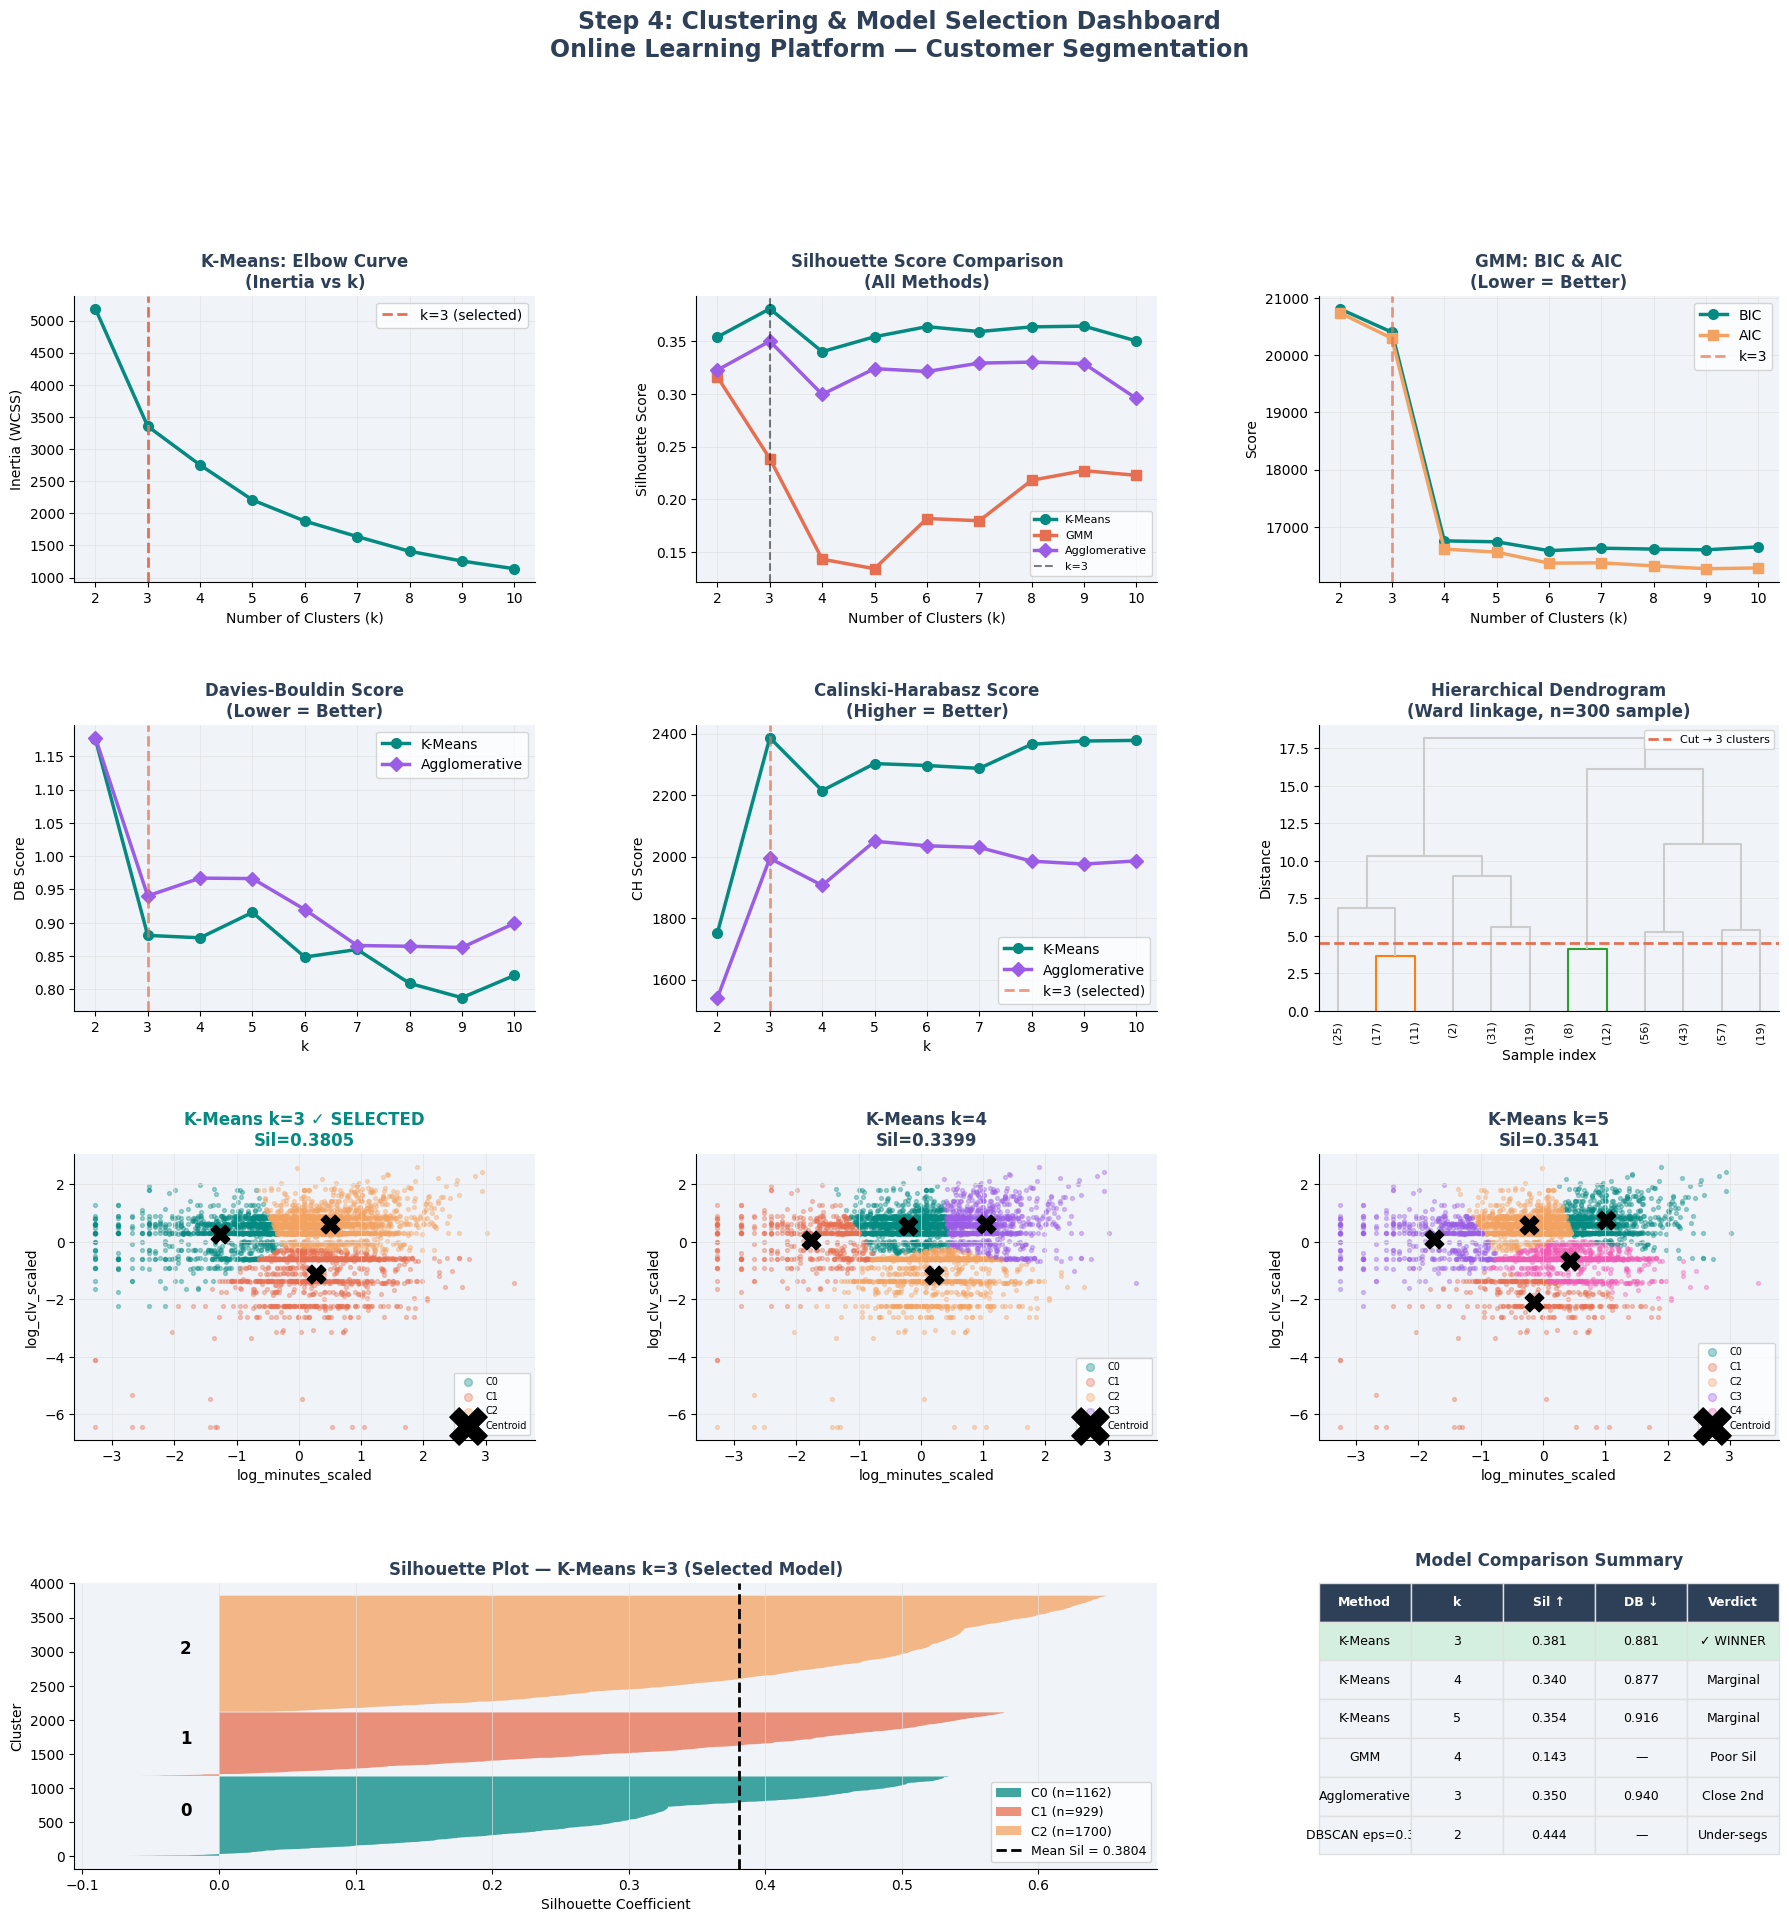


Dashboard saved → clustering_dashboard.png


In [27]:
COLORS = {
    'primary': '#2E4057', 'accent1': '#048A81', 'accent2': '#E76F51',
    'accent3': '#F4A261', 'accent4': '#9B5DE5', 'accent5': '#F15BB5',
    'light':   '#F0F4F8', 'grid':    '#E0E0E0'
}
CLUSTER_PALETTE = ['#048A81', '#E76F51', '#F4A261', '#9B5DE5', '#F15BB5', '#00BBF9', '#2E4057']
ks = list(K_RANGE)

fig = plt.figure(figsize=(22, 26), facecolor='white')
fig.suptitle('Step 4: Clustering & Model Selection Dashboard\n'
             'Online Learning Platform — Customer Segmentation',
             fontsize=17, fontweight='bold', color=COLORS['primary'], y=0.99)
gs = gridspec.GridSpec(5, 3, figure=fig, hspace=0.50, wspace=0.35)

# ── Plot 1: Elbow Curve ───────────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(ks, km_inertia, 'o-', color=COLORS['accent1'], lw=2.5, ms=7)
ax1.axvline(3, color=COLORS['accent2'], lw=2, linestyle='--', label='k=3 (selected)')
ax1.set_title('K-Means: Elbow Curve\n(Inertia vs k)', fontweight='bold', color=COLORS['primary'])
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.legend(); ax1.set_xticks(ks)
ax1.set_facecolor(COLORS['light']); ax1.grid(color=COLORS['grid'], lw=0.5)
ax1.spines[['top', 'right']].set_visible(False)

# ── Plot 2: Silhouette Score All Methods ──────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(ks, km_sil,  'o-', color=COLORS['accent1'], lw=2.5, ms=7, label='K-Means')
ax2.plot(ks, gmm_sil, 's-', color=COLORS['accent2'], lw=2.5, ms=7, label='GMM')
ax2.plot(ks, agg_sil, 'D-', color=COLORS['accent4'], lw=2.5, ms=7, label='Agglomerative')
ax2.axvline(3, color='black', lw=1.5, linestyle='--', alpha=0.5, label='k=3')
ax2.set_title('Silhouette Score Comparison\n(All Methods)', fontweight='bold', color=COLORS['primary'])
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.legend(fontsize=8); ax2.set_xticks(ks)
ax2.set_facecolor(COLORS['light']); ax2.grid(color=COLORS['grid'], lw=0.5)
ax2.spines[['top', 'right']].set_visible(False)

# ── Plot 3: GMM BIC & AIC ─────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(ks, gmm_bic, 'o-', color=COLORS['accent1'], lw=2.5, ms=7, label='BIC')
ax3.plot(ks, gmm_aic, 's-', color=COLORS['accent3'], lw=2.5, ms=7, label='AIC')
ax3.axvline(3, color=COLORS['accent2'], lw=2, linestyle='--', alpha=0.7, label='k=3')
ax3.set_title('GMM: BIC & AIC\n(Lower = Better)', fontweight='bold', color=COLORS['primary'])
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Score')
ax3.legend(); ax3.set_xticks(ks)
ax3.set_facecolor(COLORS['light']); ax3.grid(color=COLORS['grid'], lw=0.5)
ax3.spines[['top', 'right']].set_visible(False)

# ── Plot 4: Davies-Bouldin ────────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(ks, km_db,  'o-', color=COLORS['accent1'], lw=2.5, ms=7, label='K-Means')
ax4.plot(ks, agg_db, 'D-', color=COLORS['accent4'], lw=2.5, ms=7, label='Agglomerative')
ax4.axvline(3, color=COLORS['accent2'], lw=2, linestyle='--', alpha=0.7)
ax4.set_title('Davies-Bouldin Score\n(Lower = Better)', fontweight='bold', color=COLORS['primary'])
ax4.set_xlabel('k'); ax4.set_ylabel('DB Score')
ax4.legend(); ax4.set_xticks(ks)
ax4.set_facecolor(COLORS['light']); ax4.grid(color=COLORS['grid'], lw=0.5)
ax4.spines[['top', 'right']].set_visible(False)

# ── Plot 5: Calinski-Harabasz ─────────────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(ks, km_ch,  'o-', color=COLORS['accent1'], lw=2.5, ms=7, label='K-Means')
ax5.plot(ks, agg_ch, 'D-', color=COLORS['accent4'], lw=2.5, ms=7, label='Agglomerative')
ax5.axvline(3, color=COLORS['accent2'], lw=2, linestyle='--', alpha=0.7, label='k=3 (selected)')
ax5.set_title('Calinski-Harabasz Score\n(Higher = Better)', fontweight='bold', color=COLORS['primary'])
ax5.set_xlabel('k'); ax5.set_ylabel('CH Score')
ax5.legend(); ax5.set_xticks(ks)
ax5.set_facecolor(COLORS['light']); ax5.grid(color=COLORS['grid'], lw=0.5)
ax5.spines[['top', 'right']].set_visible(False)

# ── Plot 6: Dendrogram ────────────────────────────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])
np.random.seed(42)
X_sample = X[np.random.choice(len(X), 300, replace=False)]
Z = linkage(X_sample, method='ward')
dendrogram(Z, ax=ax6, truncate_mode='lastp', p=12, color_threshold=4.5,
           above_threshold_color='#cccccc', leaf_rotation=90, leaf_font_size=8)
ax6.axhline(y=4.5, color=COLORS['accent2'], lw=2, linestyle='--', label='Cut → 3 clusters')
ax6.set_title('Hierarchical Dendrogram\n(Ward linkage, n=300 sample)',
              fontweight='bold', color=COLORS['primary'])
ax6.set_xlabel('Sample index'); ax6.set_ylabel('Distance')
ax6.legend(fontsize=8)
ax6.set_facecolor(COLORS['light']); ax6.grid(axis='y', color=COLORS['grid'], lw=0.5)
ax6.spines[['top', 'right']].set_visible(False)

# ── Plots 7–9: Cluster Scatter for k=3,4,5 ───────────────────────────────────
for i, k in enumerate([3, 4, 5]):
    ax = fig.add_subplot(gs[2, i])
    km_tmp = KMeans(n_clusters=k, init='k-means++', n_init=30, random_state=42)
    lbl    = km_tmp.fit_predict(X)
    for c in range(k):
        mask = lbl == c
        ax.scatter(X[mask, 0], X[mask, 1], c=CLUSTER_PALETTE[c],
                   s=8, alpha=0.35, label=f'C{c}')
    ax.scatter(km_tmp.cluster_centers_[:, 0], km_tmp.cluster_centers_[:, 1],
               c='black', s=180, marker='X', zorder=5, label='Centroid')
    sil = silhouette_score(X, lbl)
    title_color = COLORS['accent1'] if k == 3 else COLORS['primary']
    selected    = ' ✓ SELECTED' if k == 3 else ''
    ax.set_title(f'K-Means k={k}{selected}\nSil={sil:.4f}',
                 fontweight='bold', color=title_color)
    ax.set_xlabel('log_minutes_scaled'); ax.set_ylabel('log_clv_scaled')
    ax.legend(fontsize=7, markerscale=2)
    ax.set_facecolor(COLORS['light']); ax.grid(color=COLORS['grid'], lw=0.5)
    ax.spines[['top', 'right']].set_visible(False)

# ── Plot 10: Silhouette Plot for k=3 ─────────────────────────────────────────
ax10     = fig.add_subplot(gs[3, 0:2])
sil_vals = silhouette_samples(X, labels)
y_lower  = 10
for c in range(FINAL_K):
    c_sil   = np.sort(sil_vals[labels == c])
    y_upper = y_lower + c_sil.shape[0]
    ax10.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil,
                        facecolor=CLUSTER_PALETTE[c], alpha=0.75,
                        label=f'C{c} (n={c_sil.shape[0]})')
    ax10.text(-0.02, y_lower + 0.5 * c_sil.shape[0], str(c),
              ha='right', fontsize=12, fontweight='bold')
    y_lower = y_upper + 10
ax10.axvline(sil_final, color='black', lw=2, linestyle='--', label=f'Mean Sil = {sil_final:.4f}')
ax10.set_title('Silhouette Plot — K-Means k=3 (Selected Model)',
               fontweight='bold', color=COLORS['primary'])
ax10.set_xlabel('Silhouette Coefficient'); ax10.set_ylabel('Cluster')
ax10.legend(fontsize=9)
ax10.set_facecolor(COLORS['light']); ax10.grid(axis='x', color=COLORS['grid'], lw=0.5)
ax10.spines[['top', 'right']].set_visible(False)

# ── Plot 11: Model Comparison Summary Table ───────────────────────────────────
ax11 = fig.add_subplot(gs[3, 2])
ax11.axis('off')
table_data = [
    ['Method',          'k', 'Sil ↑', 'DB ↓',  'Verdict'],
    ['K-Means',         '3', '0.381', '0.881',  '✓ WINNER'],
    ['K-Means',         '4', '0.340', '0.877',  'Marginal'],
    ['K-Means',         '5', '0.354', '0.916',  'Marginal'],
    ['GMM',             '4', '0.143', '—',      'Poor Sil'],
    ['Agglomerative',   '3', '0.350', '0.940',  'Close 2nd'],
    ['DBSCAN eps=0.30', '2', '0.444', '—',      'Under-segs'],
]
tbl = ax11.table(cellText=table_data[1:], colLabels=table_data[0],
                 cellLoc='center', loc='center', bbox=[0, 0.05, 1, 0.95])
tbl.auto_set_font_size(False); tbl.set_fontsize(9)
for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_facecolor(COLORS['primary'])
        cell.set_text_props(color='white', fontweight='bold')
    elif r == 1:
        cell.set_facecolor('#D4EFDF')
    else:
        cell.set_facecolor(COLORS['light'])
    cell.set_edgecolor(COLORS['grid'])
ax11.set_title('Model Comparison Summary', fontweight='bold',
               color=COLORS['primary'], pad=12)

plt.savefig('clustering_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("\nDashboard saved → clustering_dashboard.png")

### Save Outputs

In [26]:
df.to_csv("customer_segmentation_clustered.csv")
print(f"Clustered dataset saved")

Clustered dataset saved
